<a id="top"></a>
# UN SDG Indicator 6.6.1:<br> Change in the Extent of Water-related Ecosystems


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

In the first section, one time period is analyzed. The mean of water classifications over time is visualized, the minimum and maximum water extents are visualized, and the frequency of water classification for each pixel is visualized.

In the second section, two time periods are analyzed - a baseline time period and an analysis time period. The change in pixels that are water at any time during their respective time periods is calculated, the change in water from the baseline time period to the analysis time period is visualized, and the area is classified by degree of change using classification labels provided by UN SDG 6.6.1.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Analyze a Single Time Period](#single_period)
    * [Define the Extents of the Analysis](#define_extents_single) (selecting too much can make the acquisition process slow)
    * [Retrieve the Data from the Datacube](#retrieve_data_single)
    * [Get Water Classifications](#calculate_single)
    * [Prepare for Visualization](#prepare_for_vis)
    * [Create Time Series Plot of the Mean of Water](#time_series_water)
    * [Find the Minimum and Maximum Water Extents](#find_water_extents)
    * [Create Water Extent Image](#water_extent_image)
* [Compare Two Time Periods - a Baseline and an Analysis](#two_period)
    * [Define the Extents of the Analysis](#define_extents_baseline_analysis)
    * [Retrieve the Data from the Datacube](#retrieve_data_baseline_analysis)
    * [Get Water Classifications](#calculate_baseline_analysis)
    * [Calculate Change in Water from the Baseline Period to the Analysis Period](#calculate_water_change)
    * [Create a Change Figure](#change_figure)
    * [Classify the Area by Degree of Change](#classify_by_degree_change)

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.ama_utils import data_access_api
from utils.data_cube_utilities.ama_utils.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <a id="plat_prod"></a>Choose Platform and Product [&#9652;](#top)

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_level1_usgs


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
4,LANDSAT_8,ls8_l1_pc_usgs
1,LANDSAT_8,ls8_level1_usgs


**Choose products**

In [5]:
platform = "LANDSAT_8"
product = "ls8_level1_usgs"
output_crs = "EPSG:32756"
resolution = (-30,30)

## <a id="single_period"></a>Analyze a Single Time Period  [&#9652;](#top)

### <a id="define_extents_single"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify an area to analyze**

In [6]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

# Australia - New South Wales
# lat_small = (-31.9, -32.0) # Manning River 1
# lon_small = (152.5, 152.65) # Manning River 1
lat_small = (-31.9, -31.85) # Manning River 2
lon_small = (152.625, 152.7) # Manning River 2

**Determine the available date range**

In [7]:
from utils.data_cube_utilities.ama_utils.dc_load import get_product_extents

# Determine the date range.
_, _, min_max_dates = \
    get_product_extents(api, platform, product, latitude=(lat_small[0], lat_small[0]), 
                        longitude=(lon_small[0], lon_small[0]), output_crs=output_crs, 
                        resolution=resolution)
print("Beginning and ending dates available:", min_max_dates)

Beginning and ending dates available: (datetime.datetime(2017, 3, 5, 23, 43, 8, 71000), datetime.datetime(2018, 9, 16, 23, 42, 56, 965000))


/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/ama_utils/data_access_api.py:184: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:
/home/localuser/Datacube/datacube-core/datacube/utils/__init__.py:221: RuntimeWarning: invalid value encountered in double_scalars
  res = (data[data.size - 1] - data[0]) / (data.size - 1.0)


**Specify start and end dates**

In [8]:
# Select a subset of the time available.
date_range = [dt.datetime(2017,1,1), dt.datetime(2017,12,1)]

**Visualize the selected area**

In [9]:
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
display_map(lat_small, lon_small)

### <a id="retrieve_data_single"></a>Retrieve the Data from the Datacube [&#9652;](#top)

**Define functions for acquiring clean masks**

In [10]:
from utils.data_cube_utilities.ama_utils.dc_mosaic import unpack_bits, \
    ls5_unpack_qa, ls7_unpack_qa, ls8_unpack_qa
from xarray.ufuncs import logical_and as xr_and
from xarray.ufuncs import logical_or  as xr_or

def ls8_lv1_unpack_quality(quality, cover_type):
    """
    Returns a mask for the Landsat 8 OLI data we are using based on its 'quality' band
    and the specified `cover_type`.
    """
    land_cover_encoding = dict(
        fill         =[1], 
        terrain_occ  =[2, 2722],
        clear        =[2720, 2724, 2728, 2732],
        rad_sat_1_2  =[2724, 2756, 2804, 2980, 3012, 3748, 3780, 6820, 6852, 6900, 7076, 7108, 
                       7844, 7876],
        rad_sat_3_4  =[2728, 2760, 2808, 2984, 3016, 3752, 3784, 6824, 6856, 6904, 7080, 7112, 
                       7848, 7880],
        rad_sat_5_pls=[2732, 2764, 2812, 2988, 3020, 3756, 3788, 6828, 6860, 6908, 7084, 7116, 
                       7852, 7884],
        cloud        =[2800, 2804, 2808, 2812, 6896, 6900, 6904, 6908],
        low_conf_cl  =[2752, 2722, 2724, 2728, 2732, 2976, 2980, 2984, 2988, 3744, 3748, 3752, 
                       3756, 6816, 6820, 6824, 6828, 7072, 7076, 7080, 7084, 7840, 7844, 7848, 7852],
        med_conf_cl  =[2752, 2756, 2760, 2764, 3008, 3012, 3016, 3020, 3776, 3780, 3784, 3788, 
                       6848, 6852, 6856, 6860, 7104, 7108, 7112, 7116, 7872, 7876, 7880, 7884],
        high_conf_cl =[2800, 2804, 2808, 2812, 6896, 6900, 6904, 6908],
        high_cl_shdw =[2976, 2980, 2984, 2988, 3008, 3012, 3016, 3020, 7072, 7076, 7080, 7084, 
                       7104, 7108, 7112, 7116],
        high_snow_ice=[3744, 3748, 3752, 3756, 3776, 3780, 3784, 3788, 7840, 7844, 7848, 7852, 
                       7872, 7876, 7880, 7884],
        low_conf_cir =[2720, 2722, 2724, 2728, 2732, 2752, 2756, 2760, 2764, 2800, 2804, 2808, 
                       2812, 2976, 2980, 2984, 2988, 3008, 3012, 3016, 3020, 3744, 3748, 3752, 
                       3756, 3780, 3784, 3788],
        high_conf_cir=[6816, 6820, 6824, 6828, 6848, 6852, 6856, 6860, 6896, 6900, 6904, 6908, 
                       7072, 7076, 7080, 7084, 7104, 7108, 7112, 7116, 7840, 7844, 7848, 7852, 
                       7872, 7876, 7880, 7884]
    )
    return unpack_bits(land_cover_encoding, quality, cover_type)

def ls8_lv1_quality_mask(dataset, cover_types=['clear']):
    """
    Returns a mask for `dataset` that masks out various types of terrain cover using the
    Landsat 8 level 1 quality band. Note that Landsat masks specify what to keep, not what to remove.
    This means that using `cover_types=['clear']` should keep only clear data.
    
    See the "Landsat 8 OLI" table here: https://landsat.usgs.gov/collectionqualityband.
    
    Parameters
    ----------
    dataset: xarray.Dataset
        An xarray (usually produced by `datacube.load()`) that contains a `pixel_qa` data 
        variable.
    cover_types: list
        A list of the cover types to include. Adding a cover type allows it to remain in the masked data.
        Cover types for Landsat 8 OLI data includes: 
        ['fill', 'terrain_occ', 'clear', 'rad_sat_1_2', 'rad_sat_3_4', 'rad_sat_5_pls', 
         'cloud', 'low_conf_cl', 'med_conf_cl', 'high_conf_cl', 'high_cl_shdw', 'high_snow_ice', 
         'low_conf_cir', 'high_conf_cir'].
        
        'fill' removes "no_data" values, which indicates an absense of data. This value is -9999 for Landsat platforms.
        Generally, don't use 'fill'.
        'terrain_occ' allows only occluded terrain.
        'clear' allows only clear terrain. 'water' allows only water. 'shadow' allows only cloud shadows.
        The 'rad_sat' bands stand for radiometric saturation. See the document linked in this function's
        description above and this document regarding oversaturation: https://landsat.usgs.gov/oversaturation.
        'cloud' allows only clouds, but note that it often only selects cloud boundaries. 
        'low_conf_cl', 'med_conf_cl', and 'high_conf_cl' denote low, medium, and high confidence in cloud coverage.
        'low_conf_cl' is useful on its own for only removing clouds, however, 'clear' is usually better suited for this.
        'med_conf_cl' is useful in combination with 'low_conf_cl' to allow slightly heavier cloud coverage.
        Note that 'med_conf_cl' and 'cloud' are very similar.
        'high_conf_cl' is useful in combination with both 'low_conf_cl' and 'med_conf_cl'.
        'high_cl_shdw' denotes high confidence in cloud shadow.
        'high_snow_ice' denotes high confidence in snow or ice. 
        'low_conf_cir' and 'high_conf_cir' denote low and high confidence in cirrus clouds.
        
    Returns
    -------
    mask: xarray.DataArray
        An `xarray.DataArray` with the same number and order of coordinates as in `dataset`.
    """
    mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    for i, cover_type in enumerate(cover_types):
        cover_type_mask = ls8_lv1_unpack_quality(dataset.quality, cover_type)
        mask = cover_type_mask if i == 0 else xr_or(mask, cover_type_mask)
    return mask

In [11]:
from utils.data_cube_utilities.ama_utils.dc_load import load_simple

dataset = dc.load(lat = lat_small, lon = lon_small, time=date_range,
                  platform = platform, product = product,
                  output_crs = output_crs, resolution = resolution,
                  measurements = ["red","blue","green","nir","swir1", "swir2", "quality"])
x_coord, y_coord = 'x', 'y'

### <a id="calculate_single"></a> Get Water Classifications [&#9652;](#top)

In [12]:
from utils.data_cube_utilities.ama_utils.dc_water_classifier import NDWI

water_threshold = 0.05 # All NDWI values greater than `water_threshold` are considered to be water.

# Get a mask that keeps only clear data in the dataset.
clean_mask = ls8_lv1_quality_mask(dataset)
# Mask the dataset.
cleaned_dataset = dataset.where(clean_mask)
# Get water classifications and mask them.
water_arr = NDWI(dataset, band_pair=1)
water_arr = ((water_arr > water_threshold) & clean_mask).astype(np.float32)
cleaned_dataset['water'] = water_arr

### <a id='prepare_for_vis'></a> Prepare for Visualization [&#9652;](#top)

In [13]:
# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)

std_dpi = 200 # Standard image dpi.

### <a id="time_series_water"></a>Create Time Series Plot of the Mean of Water [&#9652;](#top)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


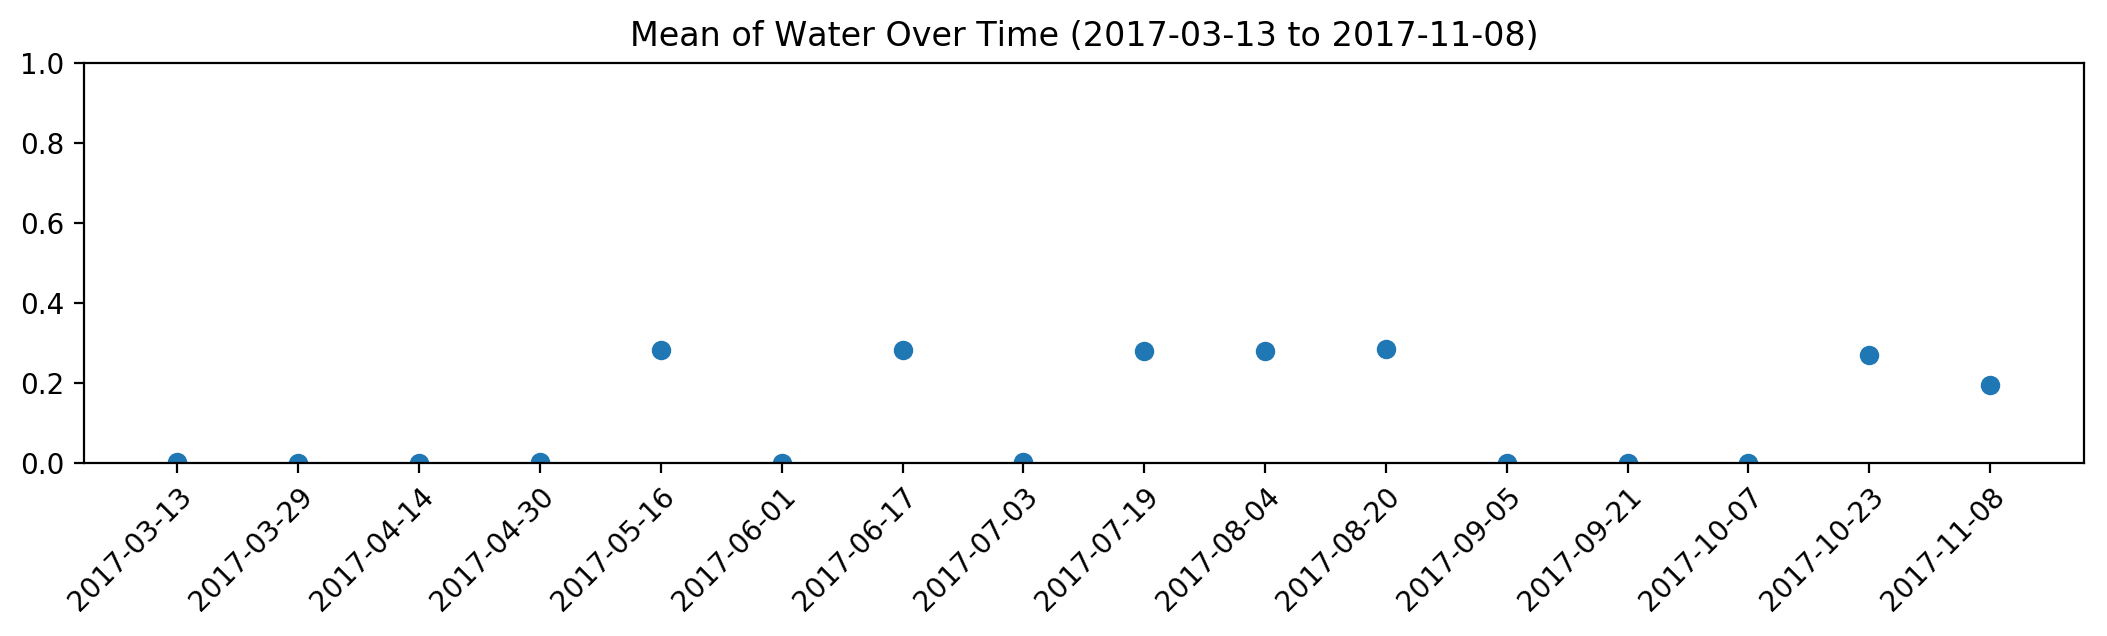

In [14]:
from utils.data_cube_utilities.ama_utils.plotter_utils import xarray_time_series_plot
from utils.data_cube_utilities.ama_utils.aggregate import xr_sel_time_by_bin

# Show only some of the times to avoid cluttering the figure with tick labels.
plotting_data = xr_sel_time_by_bin(cleaned_dataset, num_bins=min(30, len(cleaned_dataset.time)))

figsize = (10, 2) # The width and height of the figure, respectively.
fig = plt.figure(figsize=figsize, dpi=std_dpi)

xarray_time_series_plot(plotting_data, fig=fig,
                        plot_descs={'water': {'mean': [{'scatter': {}}]}},
                        show_legend=False, title='Mean of Water Over Time')
plt.ylim(0,1)
plt.show()

### <a id="find_water_extents"></a>**Find the Minimum and Maximum Water Extents** [&#9652;](#top)

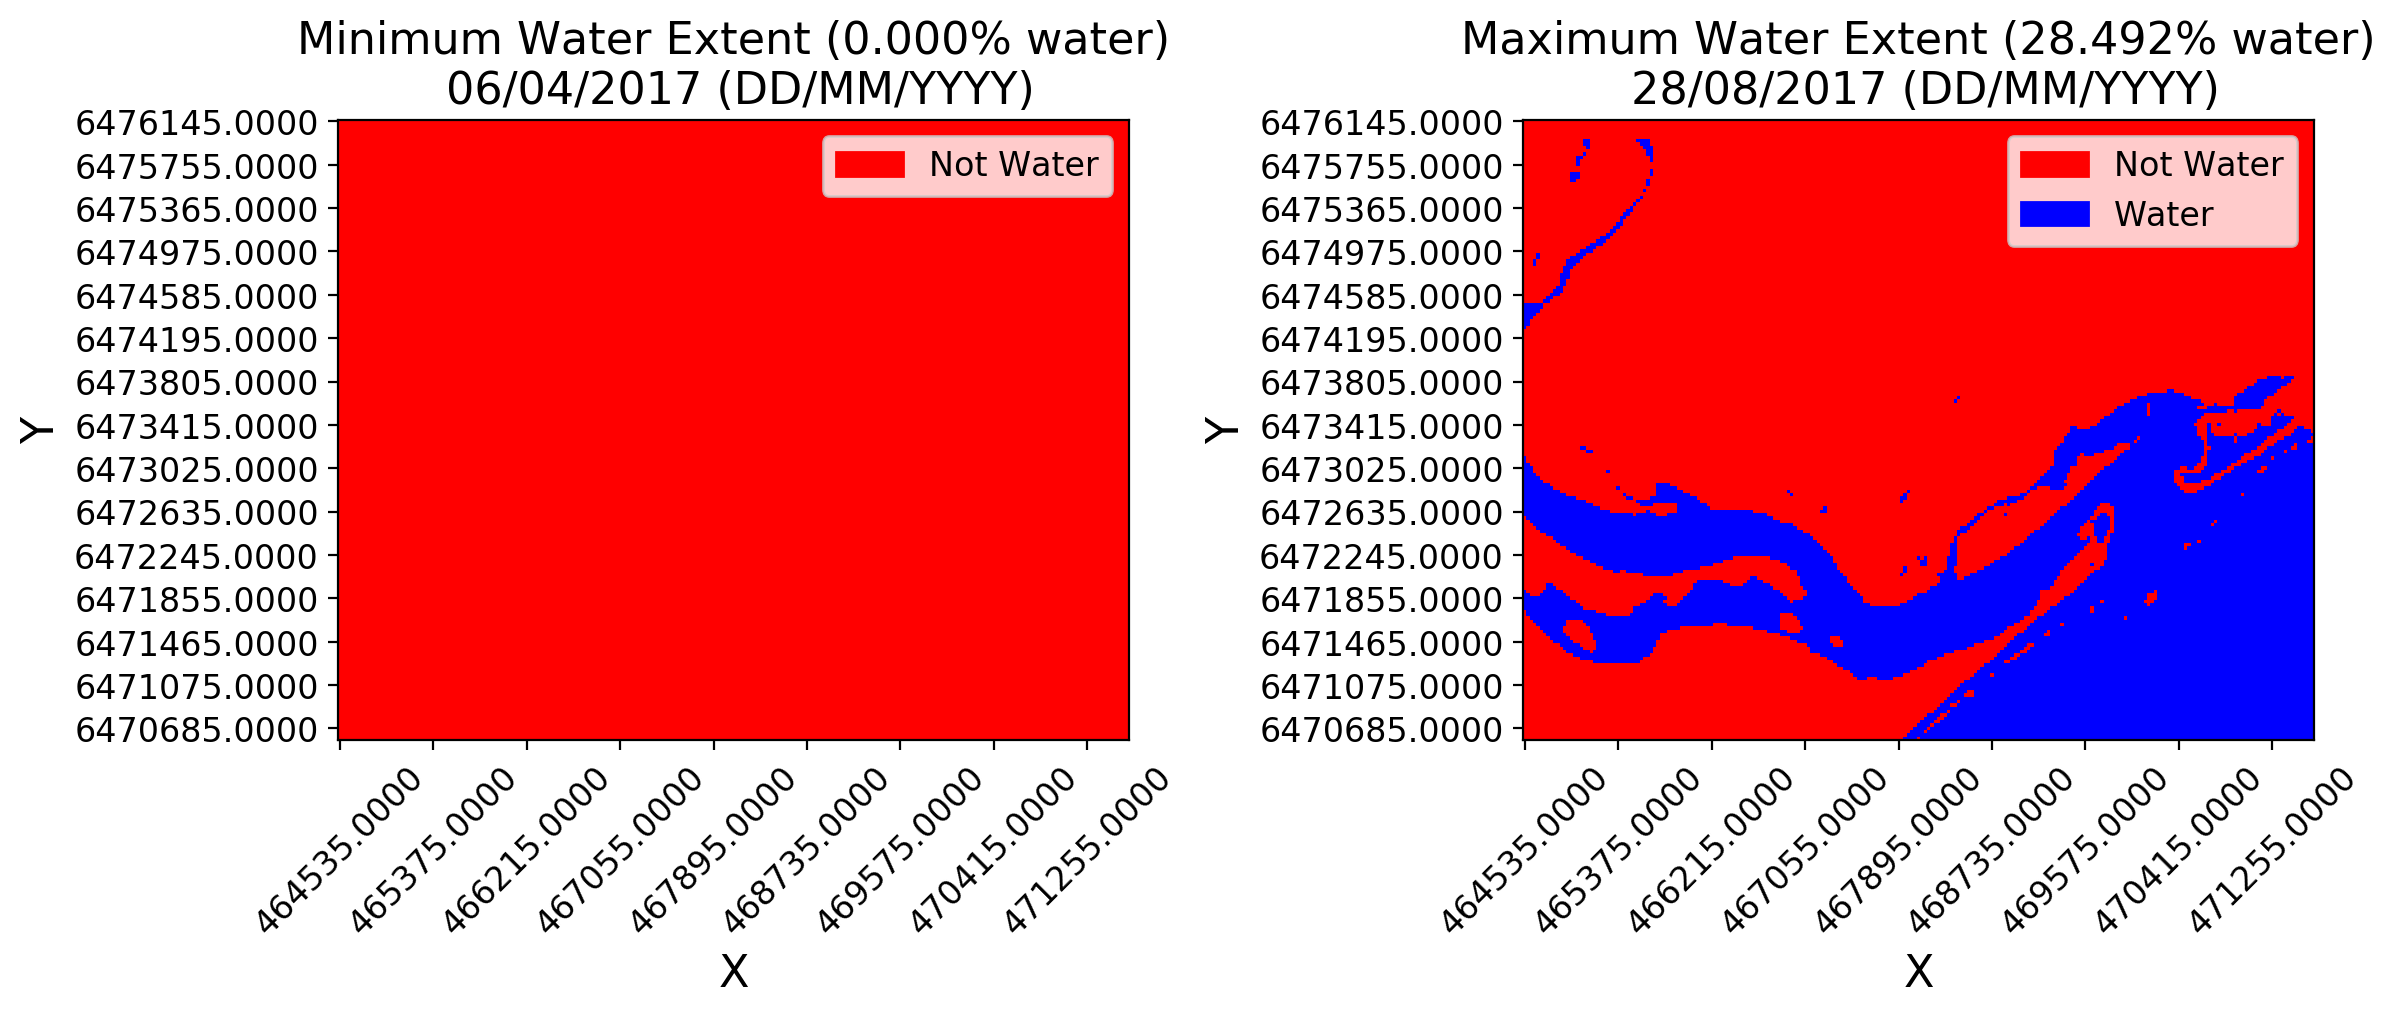

In [15]:
from utils.data_cube_utilities.ama_utils.plotter_utils import figure_ratio, create_discrete_color_map,\
                                                              xarray_imshow

# Find the acquisition with the least water.
# Treat the acquisition with the most non-water pixels as the acquisition with the least water.
min_extent_time_ind = cleaned_dataset.water.where(cleaned_dataset.water == 0)\
                      .count(dim=[y_coord, x_coord]).argmax().values
min_extent_acq = cleaned_dataset.water.isel(time=min_extent_time_ind)

# Find the acquisition with the most water.
max_extent_time_ind = cleaned_dataset.water.where(cleaned_dataset.water == 1)\
                      .count(dim=[y_coord, x_coord]).argmax().values
max_extent_acq = cleaned_dataset.water.isel(time=max_extent_time_ind)

# Begin plotting the data
fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(cleaned_dataset, x_coord=x_coord, y_coord=y_coord,
                                      fixed_width=fig_width), dpi=std_dpi)

# Create common colormap.
cmap = create_discrete_color_map([0,1], ['red', 'blue'])

imshow_kwargs = dict(vmin=0, vmax=1, cmap=cmap)

legend_labels = {0:'Not Water', 1:'Water'}

# Minimum water acqusition
ax = plt.subplot(1,2,1)
fig, ax, im, cbar = \
    xarray_imshow(min_extent_acq, x_coord=x_coord, y_coord=y_coord, fig=fig, ax=ax, 
                  use_colorbar=False, use_legend=True, legend_labels=legend_labels, 
                  imshow_kwargs=imshow_kwargs, legend_kwargs=legend_kwargs,
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict)
ax.set_title("Minimum Water Extent ({1:.3%} water)\n {0}"\
             .format(pd.to_datetime(str(min_extent_acq.time.values)).strftime('%d/%m/%Y (DD/MM/YYYY)'), 
                     np.nansum(min_extent_acq.values) / min_extent_acq.size), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

# Maximum water acqusition
ax = plt.subplot(1,2,2)
fig, ax, im, cbar = \
    xarray_imshow(max_extent_acq, x_coord=x_coord, y_coord=y_coord, fig=fig, ax=ax, 
                  use_colorbar=False, use_legend=True, legend_labels=legend_labels, 
                  imshow_kwargs=imshow_kwargs, legend_kwargs=legend_kwargs,
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict)
ax.set_title("Maximum Water Extent ({1:.3%} water)\n {0}"\
             .format(pd.to_datetime(str(max_extent_acq.time.values)).strftime('%d/%m/%Y (DD/MM/YYYY)'), 
                     np.nansum(max_extent_acq.values) / max_extent_acq.size), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

plt.tight_layout()
plt.show()

### <a id="water_extent_image"></a>**Create Water Extent Image** [&#9652;](#top)

Percent of pixels that were never water: 65.383%
Percent of pixels that were sometimes water: 34.617%
Percent of pixels that were always water: 0.000%


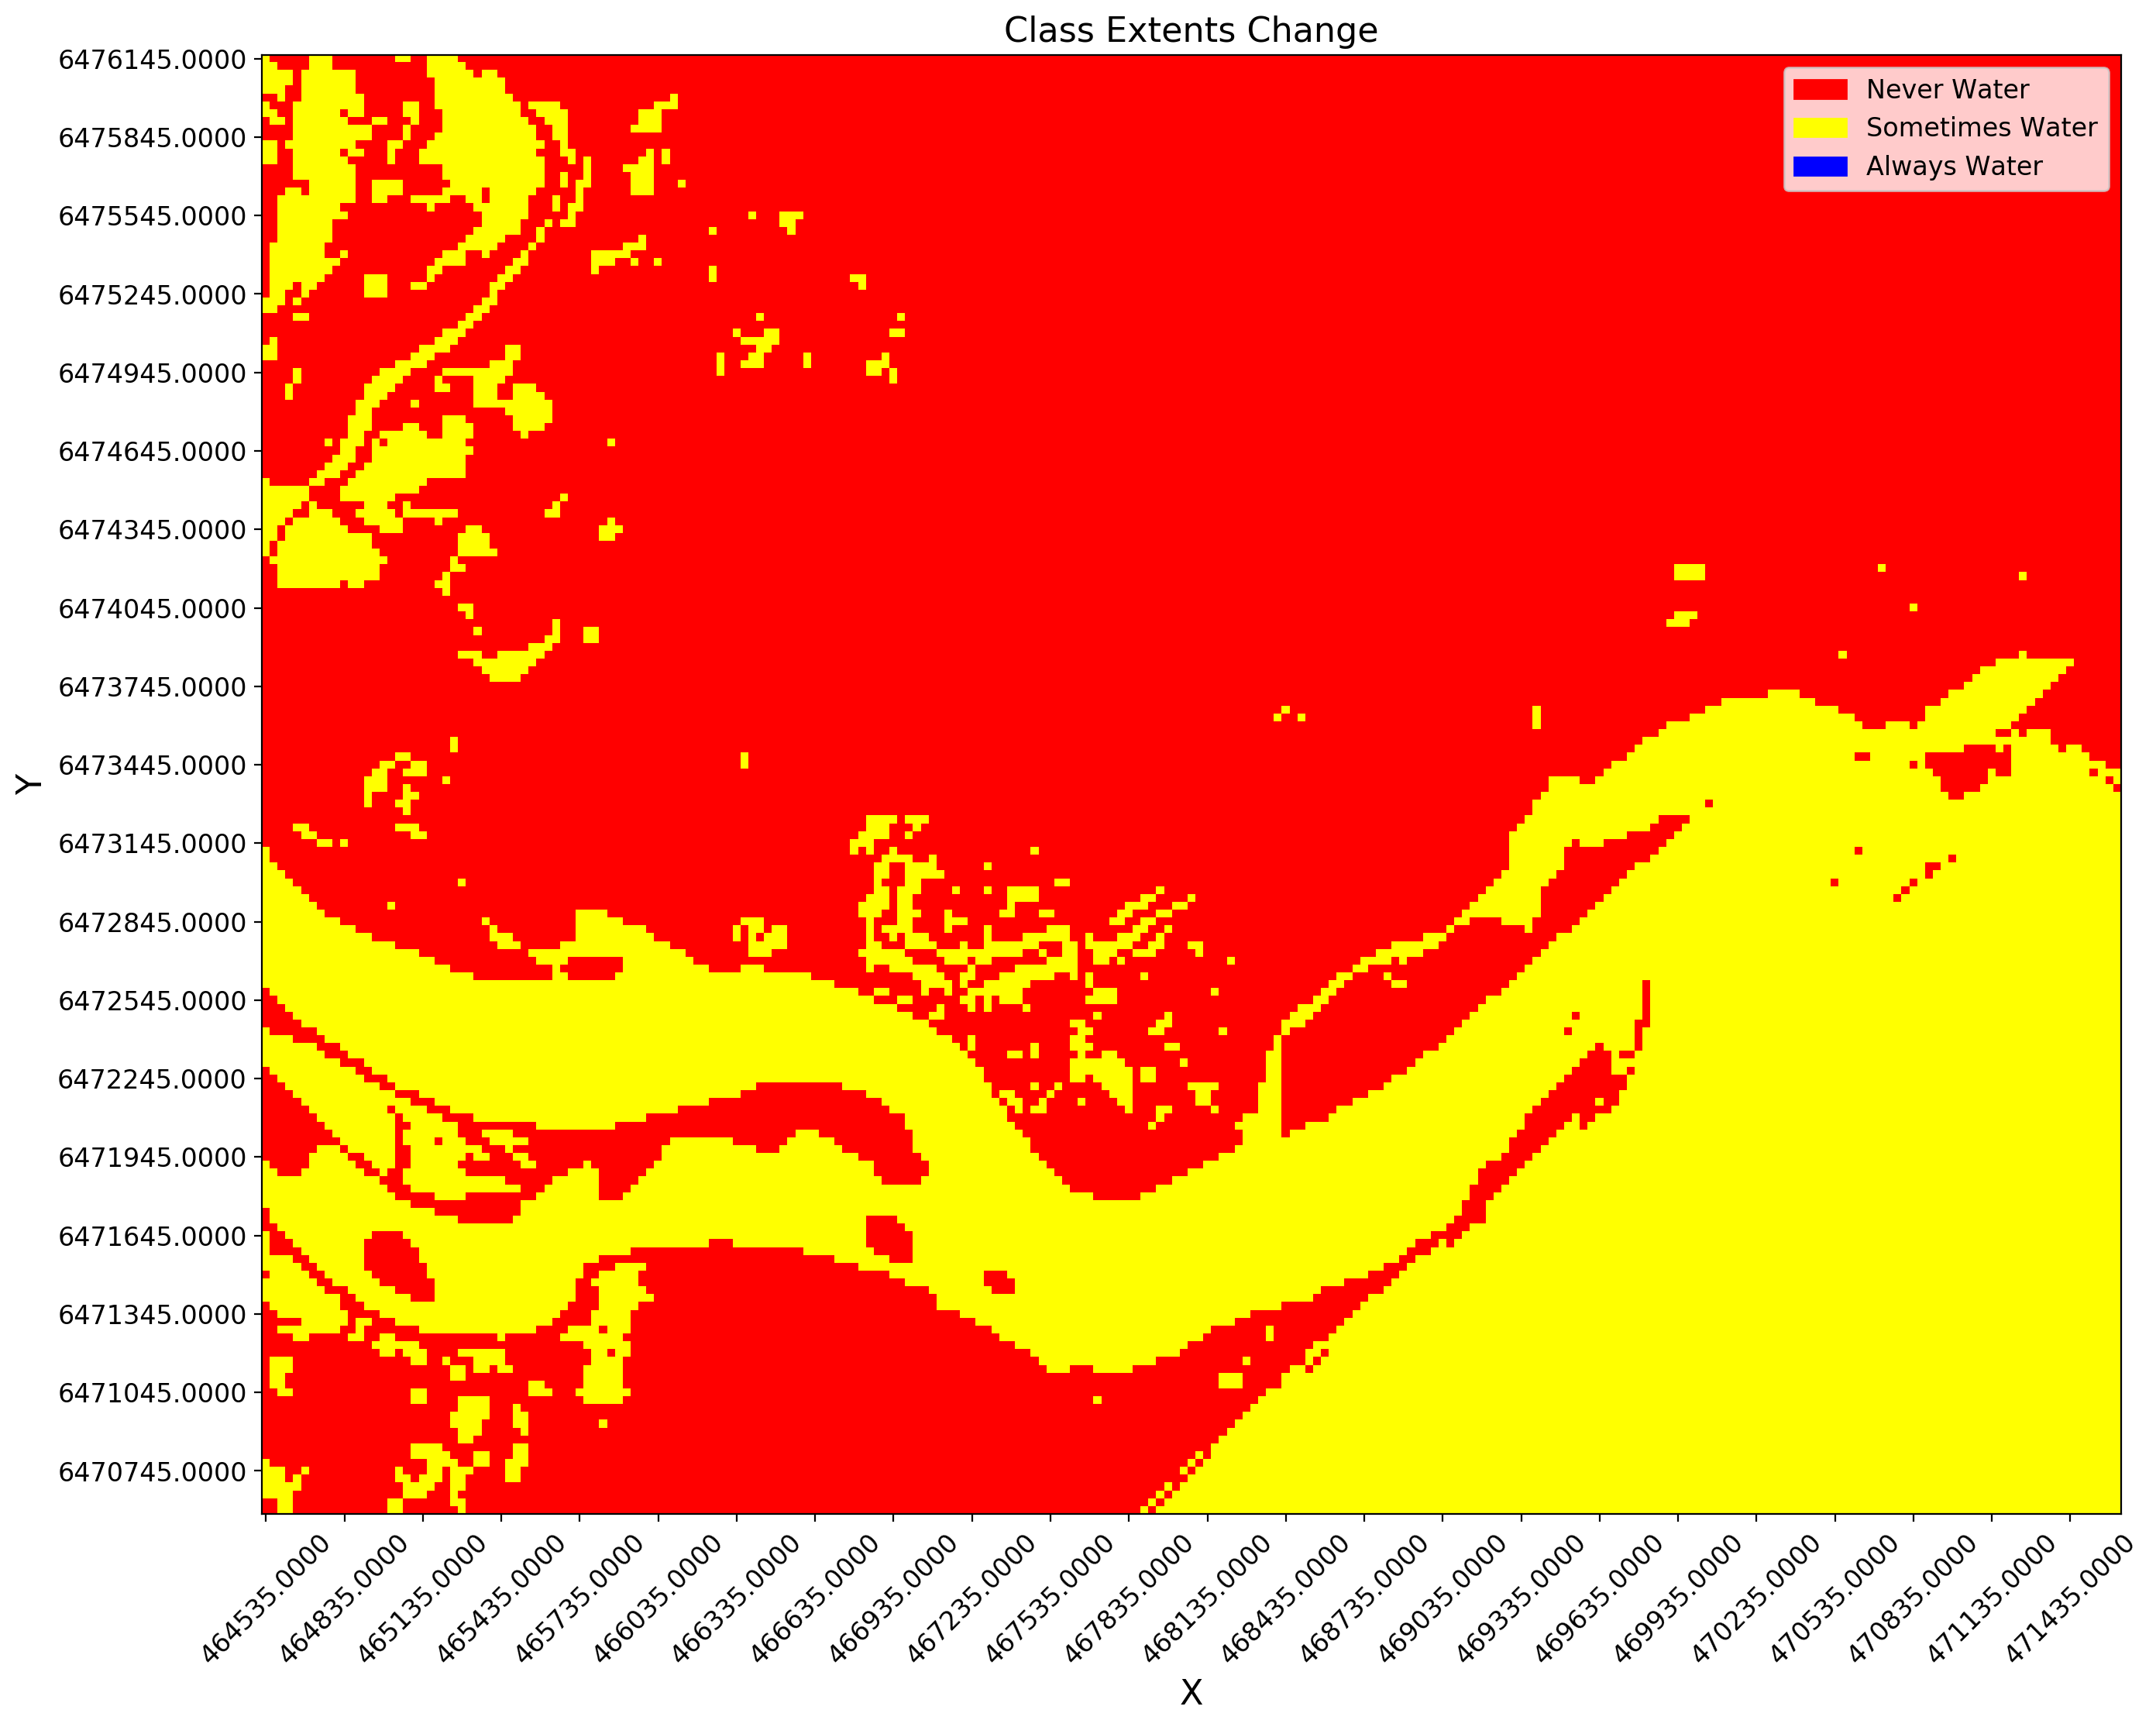

In [16]:
from utils.data_cube_utilities.ama_utils.plotter_utils import binary_class_change_plot

fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(cleaned_dataset, x_coord=x_coord, y_coord=y_coord,
                                      fixed_width=fig_width), dpi=std_dpi)

# Shade 3 regions - never, sometimes, and always water.
(fig,ax), [pct_none, pct_chng, pct_perm] = \
    binary_class_change_plot(
        [cleaned_dataset.water], colors=['red', 'yellow', 'blue'], 
        x_coord=x_coord, y_coord=y_coord,
        class_legend_label='Water', fig=fig, 
        title_kwargs=dict(fontdict=title_fontdict), 
        x_label_kwargs=axis_label_fmt_dict, 
        y_label_kwargs=axis_label_fmt_dict, 
        imshow_kwargs=imshow_kwargs, legend_kwargs=legend_kwargs)
ax.tick_params(**tick_label_fmt_dict)

print("Percent of pixels that were never water: {0:.3%}".format(pct_none))
print("Percent of pixels that were sometimes water: {0:.3%}".format(pct_chng))
print("Percent of pixels that were always water: {0:.3%}".format(pct_perm))

## <a id="two_period"></a>Compare Two Time Periods - a Baseline and an Analysis [&#9652;](#top)

### <a id="define_extents_baseline_analysis"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates in the same order as platforms and products**

In [17]:
# Select a subset of the time available.
date_ranges = {'baseline': [dt.datetime(2017,1,1), dt.datetime(2017,12,1)],
               'analysis': [dt.datetime(2018,1,1), dt.datetime(2018,12,1)]}

**Visualize the selected area**

In [18]:
display_map(lat_small, lon_small)

### <a id="retrieve_data_baseline_analysis"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [19]:
from utils.data_cube_utilities.ama_utils.dc_load import load_multiplatform

cleaned_datasets = {} # Maps categories to cleaned datasets.
clean_masks = {} # Maps categories to clean masks.
measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
# Load the baseline and analysis datasets.
for category in date_ranges.keys():
    dataset = dc.load(lat = lat_small, lon = lon_small, time=date_ranges[category],
                  platform = platform, product = product,
                  output_crs = output_crs, resolution = resolution,
                  measurements = ["red","blue","green","nir","swir1", "swir2", "quality"])
    # Get a mask that keeps only clear data in the dataset.
    clean_masks[category] = ls8_lv1_quality_mask(dataset)
    cleaned_datasets[category] = dataset.where(clean_masks[category])
del dataset # Save memory

### <a id="calculate_baseline_analysis"></a>Get Water Classifications [&#9652;](#top)

In [20]:
for category in cleaned_datasets:
    # Get water classifications and mask them.
    water_arr = NDWI(cleaned_datasets[category], band_pair=1)
    water_arr = ((water_arr > water_threshold) & clean_masks[category]).astype(np.float32)
    cleaned_datasets[category]['water'] = water_arr

### <a id="calculate_water_change"></a>**Calculate Change in Water from the Baseline Period to the Analysis Period** [&#9652;](#top)

In [21]:
baseline_ds = cleaned_datasets['baseline']
baseline_sum_cls = baseline_ds.water.sum(dim='time')
analysis_ds = cleaned_datasets['analysis']
analysis_sum_cls = analysis_ds.water.sum(dim='time')

# If a pixel was classified as water at any time during its time period, it is considered water.
baseline_frac_cls_ever = (0 < baseline_sum_cls).values.sum() / baseline_sum_cls.size
analysis_frac_cls_ever = (0 < analysis_sum_cls).values.sum() / analysis_sum_cls.size
# Calculate fractional change as the difference in the fraction of pixels ever classified as water.
frac_change_cls = (analysis_frac_cls_ever - baseline_frac_cls_ever) / baseline_frac_cls_ever
print("Between the baseline ({0} to {1}) and analysis ({2} to {3}) time periods, the change in pixels "\
      "that are water at any time during their respective time periods is:\n{4:.3%}".format(
        date_ranges['baseline'][0].strftime('%Y-%m-%d'), date_ranges['baseline'][1].strftime('%Y-%m-%d'), 
        date_ranges['analysis'][0].strftime('%Y-%m-%d'), date_ranges['analysis'][1].strftime('%Y-%m-%d'), 
        frac_change_cls))

Between the baseline (2017-01-01 to 2017-12-01) and analysis (2018-01-01 to 2018-12-01) time periods, the change in pixels that are water at any time during their respective time periods is:
2.180%


### <a id="change_figure"></a>**Create a Change Figure** [&#9652;](#top)

Percent of pixels that were never water: 70.496%
Percent of pixels that changed from no water to water: 0.685%
Percent of pixels that changed from water to no water: 0.057%
Percent of pixels that were always water: 28.762%


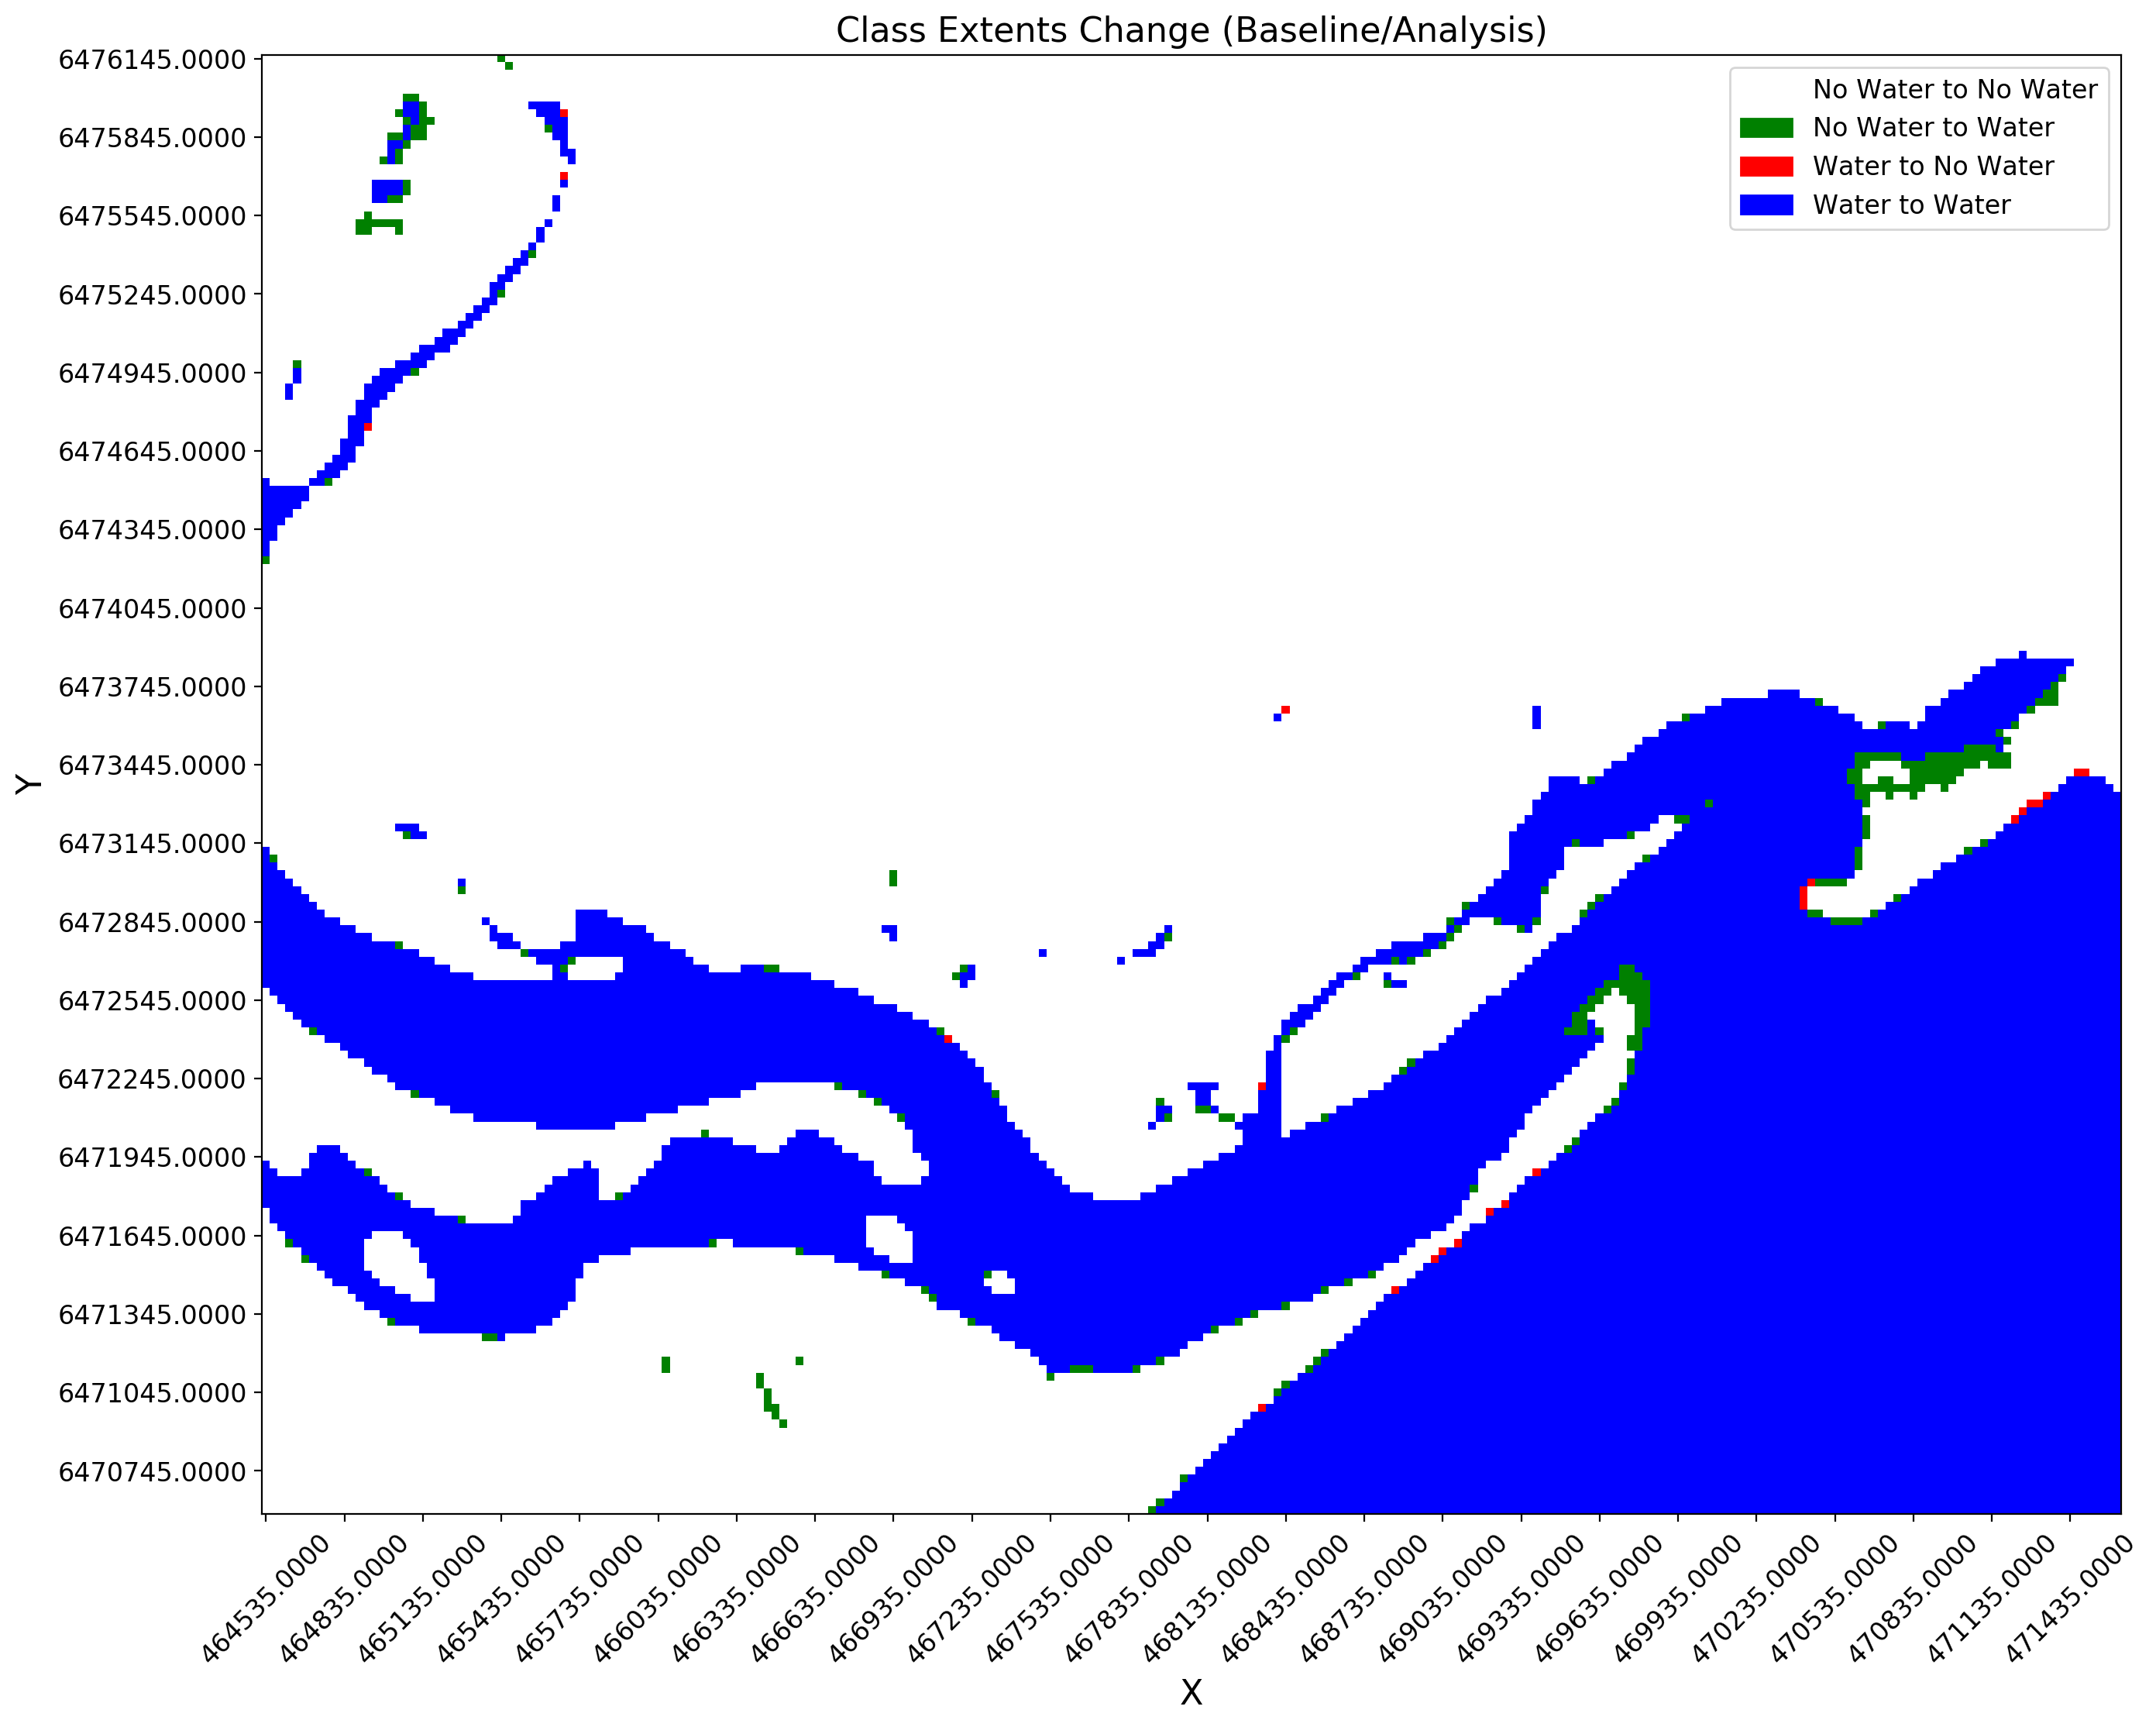

In [22]:
fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(cleaned_dataset, x_coord=x_coord, y_coord=y_coord,
                                      fixed_width=fig_width), dpi=std_dpi)

# Show regions based on changes between having zero or more than zero times in which they are classified as water 
# between the two time periods.
[fig,ax], [pct_never_never, pct_never_some, pct_some_never, pct_some_some] = \
    binary_class_change_plot(
        [baseline_ds.water, analysis_ds.water], colors=['white', 'green', 'red', 'blue'], 
        x_coord=x_coord, y_coord=y_coord,
        class_legend_label='Water', fig=fig, 
        title_kwargs=dict(fontdict=title_fontdict), 
        x_label_kwargs=axis_label_fmt_dict, 
        y_label_kwargs=axis_label_fmt_dict, 
        imshow_kwargs=imshow_kwargs, legend_kwargs=legend_kwargs)
ax.tick_params(**tick_label_fmt_dict)

print("Percent of pixels that were never water: {0:.3%}"
      .format(pct_never_never))
print("Percent of pixels that changed from no water to water: {0:.3%}"
      .format(pct_never_some))
print("Percent of pixels that changed from water to no water: {0:.3%}"
      .format(pct_some_never))
print("Percent of pixels that were always water: {0:.3%}"
      .format(pct_some_some))

plt.show()

### <a id="classify_by_degree_change"></a>**Classifiy the Area by Degree of Change** [&#9652;](#top)

In [23]:
region_class = None
frac_change_cls = abs(frac_change_cls)
if frac_change_cls <= 0.1:
    region_class = "Unmodified Natural (class A)"
if 0.1 < frac_change_cls <= 0.2:
    region_class = "Largely Natural (class B)"
if 0.2 < frac_change_cls <= 0.4:
    region_class = "Moderately Modified (class C)"
if 0.4 < frac_change_cls <= 0.6:
    region_class = "Largely Modified (class D)"
if 0.6 < frac_change_cls:
    region_class = "Seriously Modified (class E)"
print("The percent of pixels that have changed class relative to the baseline time period " \
      "is {0:.3%}, so this region can be classfied as {1}".format(frac_change_cls, region_class))

The percent of pixels that have changed class relative to the baseline time period is 2.180%, so this region can be classfied as Unmodified Natural (class A)
